In [19]:
# LOAD 2D MESH
import meshio
import numpy as np
from sympy import symbols, Eq, solve, sqrt
import matplotlib.pyplot as plt

# Load the mesh
mesh_file_path = "/home/aspadotto/meshes/square.msh"
mesh = meshio.read(mesh_file_path)

# face2node connectivity
faces = mesh.cells[0].data

# node coordinates
coords = mesh.points

# Add dummy column to host faces with more than 3 vertices
faces = np.c_[faces, -1*np.ones(faces.shape[0])]
faces = faces.astype(int)

# Sizes
Nfaces_init = faces.shape[0]
Npoints_init = coords.shape[0]
Nfaces = Nfaces_init
Npoints = Npoints_init

# Mask for elements: 0 if uncut, 1 if cut, 2 if generated by cut
cut_faces = np.zeros(Nfaces)

# central circle radius
rho = 0.25

# gamme_edge2face connectivity (not ordered, created during mesh breaking)
# in/ex mask (0: in, 1: ex, -1: cut cell)
side_mask = -1*np.ones(Nfaces)

# boundary mask
bnd_mask = np.zeros(Npoints)
for ino in range(Npoints):
    for iicoord in (0,1):
        if (abs(coords[ino,0]-0.5)<1e-6 or abs(coords[ino,0]+0.5)):
            bnd_mask = 1        
            
# ASSUMPTIONS ON MESH
## each node has list of points in counterclock-wise sense
## first 2 points of generated element are on gamma

In [6]:
print("Points: ", Npoints, "Coords: ", coords.shape)

Points:  790 Coords:  (790, 3)


cut!  [0.0500863020362089 -0.244931342111086 0.0]
cut!  [0.0733373870407795 -0.239001313096876 0.0]


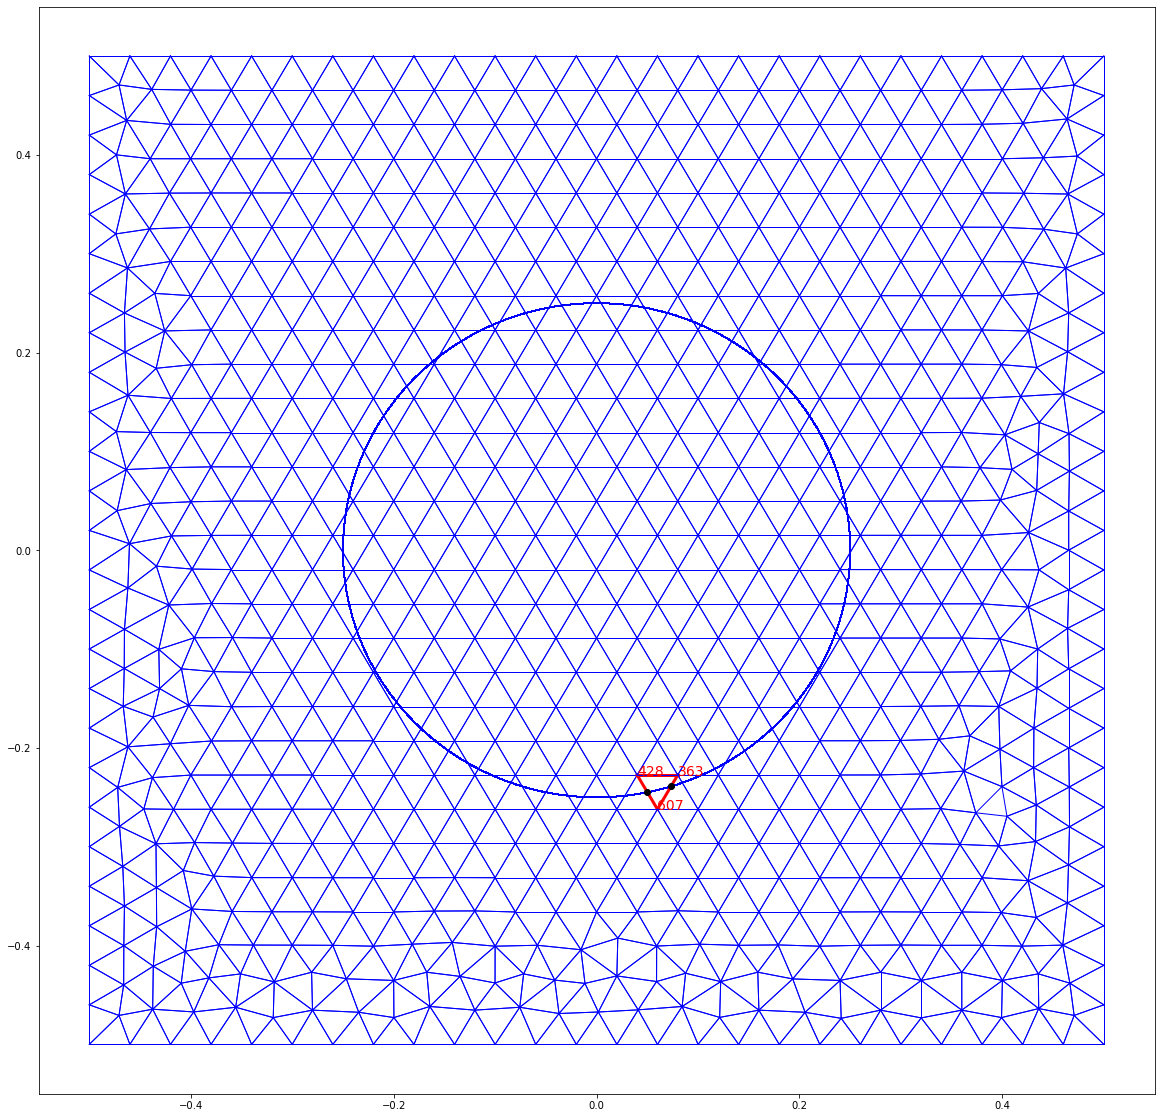

In [319]:
# visualization 

fig, ax = plt.subplots(figsize=(20,20))
for ifa in range(Nfaces-1):
    for ino in range(3):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%3],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.005)
       ax.plot(xx,yy,'b', linewidth=1)
       if (ifa==154):
          ax.plot(xx,yy,'r', linewidth=3)
          text_position = p1
          text_content = str(faces[ifa,ino])
          ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
          [cut, int_coords] = calc_intersection(p1[0], p2[0], p1[1],p2[1])
          if cut:
           #print ("cut! ",int_coords)
           ax.plot(int_coords[0],int_coords[1],'ko', linewidth=4)
       circle = plt.Circle((0, 0), radius=rho, edgecolor='b', facecolor='none')
       ax.add_patch(circle)

In [7]:
def is_proper(value):
    return (value.is_real and abs(value)<=1 and value>0)

def calc_intersection(x1,x2,y1,y2):
   # Define variables
   x, y, t= symbols('x y t')
   # Equation of the circle centered at the origin
   circle_equation = Eq(x**2 + y**2, rho**2)
   # Parametric equations of the line segment
   segment_x = x1 + (x2 - x1) * t
   segment_y = y1 + (y2 - y1) * t
   # Substitute parametric equations into the circle equation
   circle_intersection = circle_equation.subs({x: segment_x, y: segment_y})
   # Solve the resulting quadratic equation for t
   intersection_points = solve(circle_intersection, t)
   #print("Curvilinear abscissa: ", intersection_points)
   if (len(intersection_points)==0):
       return [False, np.array([0.0,0.0])]
      # Evaluate the parametric equations at the intersection points
   intersection_coordinates = \
      [(segment_x.subs(t, point), segment_y.subs(t, point)) for point in intersection_points]
   #print ("Intersection points: ", intersection_coordinates) 
   if (is_proper(intersection_points[0])):
        #print ("it's the first")
        point = intersection_coordinates[0]
        return [True, np.array([point[0], point[1],0.0])]
   elif (is_proper(intersection_points[1])):
        #print ("it's the second")
        point = intersection_coordinates[1]
        return [True, np.array([point[0], point[1],0.0])]
   else:
        return [False, np.array([0.0,0.0,0.0])]

In [8]:
# check if face is cut
def is_cut(ifa):
    r_min = 1e6
    r_max = 0
    for ino in range(3):
        r = np.linalg.norm(coords[faces[ifa,ino]])
        if (r<=r_min):
            r_min = r
        if (r>=r_max):
            r_max = r
    if (r_min<=rho and rho<=r_max):
        return True
    
# check if point is present
def check_if_present(node_coords):
   for ino in range(Npoints):
        diff = node_coords-coords[ino]
        if (np.dot(diff,diff)<1e-10):
            print ("Point already there")
            return [True, ino]
   return [False, -1] 

In [9]:
def split_face(ifa):
    global Npoints
    global coords
    inters_mask = [0,0,0] #Pattern of intersections to get orientation (if counter_clock)
    vert_mask   = [0,0,0] #Pattern of vertices for orientation (increase if side is cut)
    inters_found = 0      
    int1 = -1             #idx intersection
    int2 = -1 
    # Loop over Edges to find intersection
    for ie in range(3):
        ino1 = faces[ifa,ie]
        ino2 = faces[ifa, (ie+1)%3]
        point1 = coords[ino1,:]
        point2 = coords[ino2,:]
        [cut, int_coords] = calc_intersection(point1[0], point2[0], point1[1],point2[1])
        if cut:
            # Add point if not already there
            [present, idx] = check_if_present (int_coords)
            if(not present):
                Npoints = Npoints + 1
                coords = np.vstack([coords,np.array([int_coords[0], int_coords[1], 0.0])])
                idx = Npoints-1
            # Mark index
            if (inters_found == 0):
                int1 = idx
                inters_found = inters_found + 1
            else:
                int2 = idx
            # Update Vert mask
            vert_mask [ie] = vert_mask[ie] + 1
            vert_mask [(ie+1)%3] = vert_mask [(ie+1)%3] + 1
            # Update inters_mask
            inters_mask[ie] = 1
    # Get index of vertices in the right order
    vert_mask = np.array(vert_mask)
    loc_v1 = np.where(vert_mask == 2)[0][0]
    print ("vertex mask: ", vert_mask)
    print ("inters_mask: ", inters_mask)
    print("pos of v1: ",loc_v1)
    v1 = faces[ifa,loc_v1]
    v2 = faces[ifa,(loc_v1+1)%3]
    v3 = faces[ifa,(loc_v1+2)%3]
    # Put intersection in right order
    if (inters_mask==[1,1,0] or inters_mask==[0,1,1]):
        int_prec = int1
        int_fol  = int2
    else:
        int_prec = int2
        int_fol  = int1
    # Define list of ordered vertices of new elements (the triangle first)
    # Notice that cut edge is the first
    l1 = [int_fol,int_prec,v1,-1]
    l2 = [int_prec,int_fol,v2,v3]
    return [l1,l2]
    
            

In [20]:
# MESH BREAKING
for ifa in range(Nfaces_init):
    #Check if face is cut by circle
    if (is_cut(ifa)):
        print ("Face: ", ifa)
        # Mask the Face
        cut_faces[ifa] = 1
        # Create new nodes and faces
        [f1,f2] = split_face(ifa)
        print (f1,f2)
        # Update list of faces and mask
        faces = np.vstack([faces,np.array(f1)])
        faces = np.vstack([faces, np.array(f2)])
        cut_faces=np.append(cut_faces,2)
        cut_faces=np.append(cut_faces,2)
        Nfaces = Nfaces + 2
        # Update gamma_edge 
        if ("gamma_edges" in globals()):
            gamma_edges = np.vstack([gamma_edges, np.array([Nfaces-2, Nfaces-1])])
        else:
            gamma_edges = np.array([Nfaces-2, Nfaces-1])
    elif (np.linalg.norm(coords[faces[ifa,0],:])<rho):
        side_mask[ifa] = 0
    else:
        side_mask[ifa] = 1
        
        

Face:  128
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[790, 791, 363, -1] [791, 790, 607, 368]
Face:  133
vertex mask:  [1 2 1]
inters_mask:  [1, 1, 0]
pos of v1:  1
[793, 792, 508, -1] [792, 793, 185, 155]
Face:  134
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[793, 794, 185, -1] [794, 793, 508, 480]
Face:  136
vertex mask:  [1 2 1]
inters_mask:  [1, 1, 0]
pos of v1:  1
[796, 795, 672, -1] [795, 796, 428, 506]
Face:  148
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[796, 797, 428, -1] [797, 796, 672, 607]
Face:  151
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[798, 794, 480, -1] [794, 798, 521, 185]
Face:  154
Point already there
Point already there
vertex mask:  [1 2 1]
inters_mask:  [1, 1, 0]
pos of v1:  1
[790, 797, 607, -1] [797, 790, 363, 428]
Face:  158
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[799, 792, 155, -1] [792,

Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[851, 827, 200, -1] [827, 851, 203, 635]
Face:  1039
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[862, 843, 206, -1] [843, 862, 205, 207]
Face:  1075
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[862, 863, 205, -1] [863, 862, 206, 201]
Face:  1078
Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[834, 840, 188, -1] [840, 834, 190, 574]
Face:  1079
Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[859, 863, 201, -1] [863, 859, 204, 205]
Face:  1109
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[864, 821, 282, -1] [821, 864, 669, 444]
Face:  1112
Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[835, 795, 506, -1] [795, 835, 285, 672]
Face:  1115
Point alr

In [344]:
faces[1500:1502,:]

array([[807, 806, 492,  -1],
       [806, 807, 511, 629]])

In [326]:
cut_faces[128-2:128+2]

array([0., 0., 1., 0.])

In [24]:
np.where(side_mask==0)[0]

array([ 140,  145,  159,  160,  161,  163,  168,  169,  170,  173,  174,
        175,  176,  178,  180,  183,  185,  193,  197,  198,  199,  208,
        211,  218,  219,  221,  223,  227,  229,  248,  249,  254,  255,
        257,  266,  268,  269,  275,  279,  285,  286,  295,  299,  307,
        316,  317,  318,  324,  325,  335,  340,  351,  356,  357,  372,
        375,  377,  386,  387,  392,  394,  401,  403,  409,  411,  412,
        414,  415,  418,  421,  436,  450,  464,  465,  469,  474,  476,
        478,  487,  488,  490,  500,  501,  503,  509,  530,  532,  534,
        535,  542,  543,  579,  582,  584,  595,  601,  607,  615,  622,
        627,  637,  639,  646,  651,  653,  657,  659,  661,  664,  669,
        679,  686,  690,  695,  698,  703,  709,  710,  711,  735,  742,
        744,  748,  749,  753,  754,  771,  773,  774,  777,  783,  784,
        827,  829,  832,  833,  838,  847,  850,  853,  855,  858,  859,
        862,  865,  867,  873,  886,  887,  889,  8

In [329]:
Npoints

799

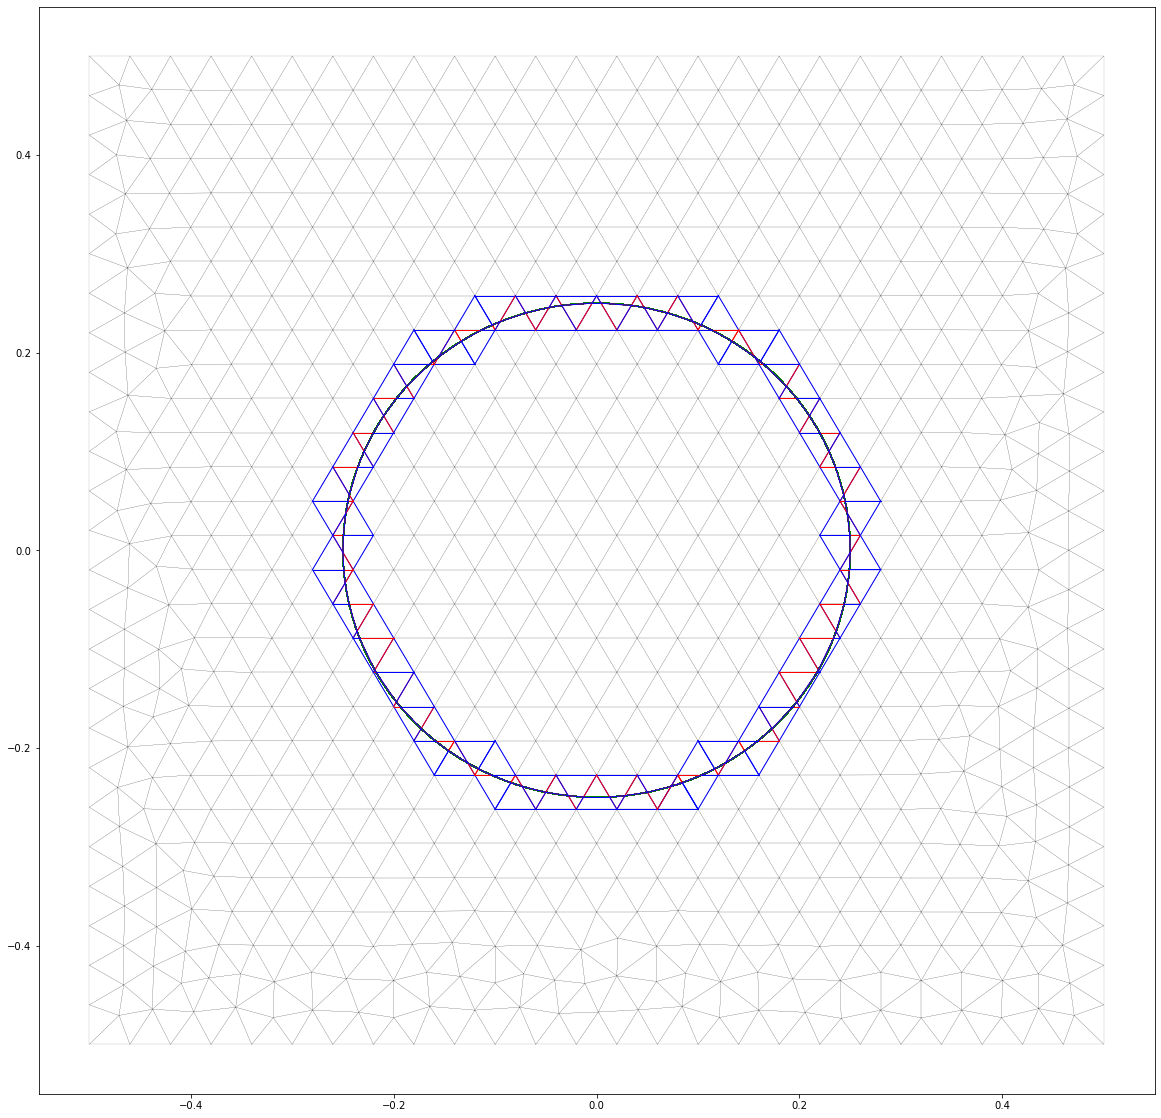

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
new_Nfaces = faces.shape[0]
for ifa in range(new_Nfaces):
    if (faces[ifa,3]==-1):
        nvert = 3
    else:
        nvert = 4
    for ino in range(nvert):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%nvert],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.1)
       if (cut_faces[ifa]==0 or cut_faces[ifa]==1):
          ax.plot(xx,yy,'k', linewidth=0.1)
       if (cut_faces[ifa]==2 and nvert ==3):
           ax.plot(xx,yy,'r', linewidth=1)
       if (cut_faces[ifa]==2 and nvert ==4):
          ax.plot(xx,yy,'b', linewidth=1)
    circle = plt.Circle((0, 0), radius=rho, edgecolor='g', facecolor='none')
    ax.add_patch(circle)